<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/searching_best_dataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install braindecode
!pip install moabb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.8/563.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 18.1 MB/s eta 0:00:00
  Created wheel for pyriemann: filename=pyriemann-0.5-py2.py3-none-any.whl size=107752 sha256=9565b082343f489f5e5f374425ac7291a736ceaac573b3fafdda

In [ ]:
from skorch.callbacks import LRScheduler

from braindecode import EEGClassifier
from braindecode.datasets import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/usr/local/lib/python3.10/dist-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_P

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 32.6GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 42.3M/42.3M [

In [ ]:
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from numpy import multiply

low_cut_hz = 4.
high_cut_hz = 38.

factor_new = 1e-3
init_block_size = 1000

factor = 1e6

In [ ]:
preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    Preprocessor(lambda data: multiply(data, factor)),
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    Preprocessor(exponential_moving_standardize,
                 factor_new=factor_new, init_block_size=init_block_size)
]

preprocess(dataset, preprocessors, n_jobs=-1)

/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [ ]:
from braindecode.preprocessing import create_windows_from_events
from skorch.helper import SliceDataset
from numpy import array

trial_start_offset_seconds = -0.5

sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']
eval_set = splitted['1test']

In [ ]:
from numpy import linspace
from braindecode.augmentation import FTSurrogate, SmoothTimeMask, ChannelsDropout

seed = 20200220

transforms_freq = [FTSurrogate(probability=0.5, phase_noise_magnitude=phase_freq,
                               random_state=seed) for phase_freq in linspace(0, 1, 2)]

transforms_time = [SmoothTimeMask(probability=0.5, mask_len_samples=int(sfreq * second),
                                  random_state=seed) for second in linspace(0.1, 2, 2)]

transforms_spatial = [ChannelsDropout(probability=0.5, p_drop=prob,
                                      random_state=seed) for prob in linspace(0, 1, 2)]

In [ ]:
import torch

from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

In [ ]:
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))

n_channels = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_channels,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)


/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [ ]:
from braindecode.augmentation import AugmentedDataLoader

if cuda:
    model.cuda()

In [ ]:
lr = 0.0625 * 0.01
weight_decay = 0

batch_size = 64
n_epochs = 2

clf = EEGClassifier(
    model,
    iterator_train=AugmentedDataLoader,
    iterator_train__transforms=[],
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        'accuracy',
        ('lr_scheduler', LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes
)

In [ ]:
train_X = SliceDataset(train_set, idx=0)
train_y = array(list(SliceDataset(train_set, idx=1)))

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

cv = KFold(n_splits=2, shuffle=True, random_state=seed)
fit_params = {'epochs': n_epochs}

transforms = transforms_freq + transforms_time + transforms_spatial

param_grid = {
    'iterator_train__transforms': transforms,
}

clf.verbose = 0

search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    return_train_score=True,
    scoring='accuracy',
    refit=True,
    verbose=1,
    error_score='raise')

search.fit(train_X, train_y, **fit_params)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=20200220, shuffle=True),
             error_score='raise',
             estimator=<class 'braindecode.classifier.EEGClassifier'>[uninitialized](
  module=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Ou...
  Estimated Total Size (MB): 0.50
  ============================================================================================================================================,
),
             param_grid={'iterator_train__transforms': [FTSurrogate(),
                                                        FTSurrogate(),
                                                        SmoothTimeMask(),
                                                        SmoothTimeMask(),
                                                        ChannelsDropout(),
                                                        ChannelsDropout()]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
import pandas as pd
import numpy as np

search_results = pd.DataFrame(search.cv_results_)

best_run = search_results[search_results['rank_test_score'] == 1].squeeze()
best_aug = best_run['params']
validation_score = np.around(best_run['mean_test_score'] * 100, 2).mean()
training_score = np.around(best_run['mean_train_score'] * 100, 2).mean()

report_message = 'Best augmentation is saved in best_aug which gave a mean validation accuracy' + \
                 'of {}% (train accuracy of {}%).'.format(validation_score, training_score)

print(report_message)

eval_X = SliceDataset(eval_set, idx=0)
eval_y = SliceDataset(eval_set, idx=1)
score = search.score(eval_X, eval_y)
print(f'Eval accuracy is {score * 100:.2f}%.')

Best augmentation is saved in best_aug which gave a mean validation accuracyof 31.94% (train accuracy of 28.12%).
Eval accuracy is 25.00%.


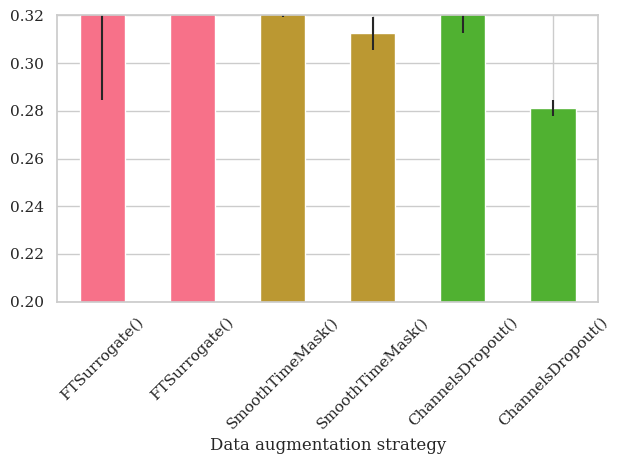

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
search_results.plot.bar(
    x="param_iterator_train__transforms", y="mean_train_score", yerr="std_train_score",
    rot=45, color=["C0", "C0", "C1", "C1", "C2", "C2"], legend=None, ax=ax)
ax.set_xlabel("Data augmentation strategy")
ax.set_ylim(0.2, 0.32)
plt.tight_layout()